# Sleep Quality Study
This dataset is from the app Sleep Cycle, between 2014 and 2018, and includes some interesting qualitative variables.

Source: https://www.kaggle.com/danagerous/sleep-data, accessed on August 13th, 2020.

## The Dataset
Number of Rows | Number of Columns | One Row Represents
------------- | ------------- | -------------
887 | 8 | One app user's night sleep

## Data Cleaning
To start, we'll clean up the data, and split up a column to create some new features.

In [ ]:
#%%capture
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn import metrics

from scipy import stats

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.graphics.regressionplots import influence_plot

#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all" # Print multiple output in one cell

try:
    import seaborn as sns
    print("Module 'seaborn' is installed")
except ModuleNotFoundError:
    %pip install seaborn
    import seaborn as sns

In [160]:
#Thanks to Jason Sadowski @ towardsdatascience.com for his article on these R-style regression diganostic plots!
#https://towardsdatascience.com/going-from-r-to-python-linear-regression-diagnostic-plots-144d1c4aa5a

def residuals_vs_fitted_plot(model: "statsmodels.smf model after .fit()"):
    residuals = model.resid
    fitted = model.fittedvalues
    smoothed = lowess(residuals,fitted)
    top3 = abs(residuals).sort_values(ascending = False)[:3]

    fig, ax = plt.subplots()
    fig.set_figwidth(8)
    fig.set_figheight(6)

    ax.set_ylabel('Residuals')
    ax.set_xlabel('Fitted Values')
    ax.set_title('Residuals vs. Fitted')

    ax.scatter(fitted, residuals, edgecolors = 'k', facecolors = 'none')
    ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')

    ax.plot([min(fitted),max(fitted)],[0,0],color = 'k',linestyle = ':', alpha = .3)

    for i in top3.index:
        ax.annotate(" " + str(i),xy=(fitted[i],residuals[i]))

    plt.show()

def qq_plot(model: "statsmodels.smf after .fit()"):
    sorted_student_residuals = pd.Series(model.get_influence().resid_studentized_internal)
    sorted_student_residuals.index = model.resid.index
    sorted_student_residuals = sorted_student_residuals.sort_values(ascending = True)

    df = pd.DataFrame(sorted_student_residuals)
    df.columns = ['sorted_student_residuals']
    df['theoretical_quantiles'] = stats.probplot(df['sorted_student_residuals'], dist = 'norm', fit = False)[0]

    rankings = abs(df['sorted_student_residuals']).sort_values(ascending = False)

    top3 = rankings[:3]
    print(top3)

    fig, ax = plt.subplots()
    x = df['theoretical_quantiles']
    y = df['sorted_student_residuals']
    ax.scatter(x, y, edgecolor = 'black', facecolor = 'none')
    ax.set_title('Normal Q-Q')
    ax.set_ylabel('Standardized Residuals')
    ax.set_xlabel('Theoretical Quantiles')

    ax.plot([np.min([x,y]), np.max([x,y])], [np.min([x,y]), np.max([x,y])], color = 'red', ls = '--')

    for val in top3.index:
        ax.annotate(" " + str(val), xy = (df['theoretical_quantiles'].loc[val], df['sorted_student_residuals'].loc[val]) )
    plt.show()

def student_standardized_residuals_vs_fitted(model: "statsmodels.smf after .fit()"):
    student_residuals = model.get_influence().resid_studentized_internal
    sqrt_student_residuals = pd.Series(np.sqrt(np.abs(student_residuals)))
    sqrt_student_residuals.index = model.resid.index
    
    smoothed = lowess(sqrt_student_residuals, model.fittedvalues)
    top3 = abs(sqrt_student_residuals).sort_values(ascending = False)[:3]

    fig, ax = plt.subplots()
    ax.scatter(model.fittedvalues, sqrt_student_residuals, edgecolors = 'black', facecolors = 'none')
    ax.plot(smoothed[:,0], smoothed[:,1], color = 'red')
    ax.set_ylabel('$\sqrt{|Studentized \ Residuals|}$')
    ax.set_xlabel('Fitted Values')
    ax.set_title('Scale-Location')
    ax.set_ylim(0, max(sqrt_student_residuals) + 0.1)

    for i in top3.index:
        ax.annotate(i,xy=(model.fittedvalues[i],sqrt_student_residuals[i]))
    plt.show()

def regression_diagnostic_plots(model: "statsmodels.smf after .fit()"):
    fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 12))

    residuals = model.resid
    fitted = model.fittedvalues
    smoothed = lowess(residuals,fitted)
    top3 = abs(residuals).sort_values(ascending = False)[:3]

    ax[0, 0].scatter(fitted, residuals, edgecolors = 'k', facecolors = 'none')
    ax[0, 0].plot(smoothed[:,0],smoothed[:,1],color = 'r')

    ax[0, 0].plot([min(fitted),max(fitted)],[0,0],color = 'k',linestyle = ':', alpha = .3)


    ax[0, 0].set_ylabel('Residuals')
    ax[0, 0].set_xlabel('Fitted Values')
    ax[0, 0].set_title('Residuals vs. Fitted')

    for i in top3.index:
        ax[0, 0].annotate(" " + str(i),xy=(fitted[i],residuals[i]))

    #plt.show()

    #------------------------------------------

    sorted_student_residuals = pd.Series(model.get_influence().resid_studentized_internal)
    sorted_student_residuals.index = model.resid.index
    sorted_student_residuals = sorted_student_residuals.sort_values(ascending = True)

    dfQQ = pd.DataFrame(sorted_student_residuals)
    dfQQ.columns = ['sorted_student_residuals']
    dfQQ['theoretical_quantiles'] = stats.probplot(dfQQ['sorted_student_residuals'], dist = 'norm', fit = False)[0]

    rankings = abs(dfQQ['sorted_student_residuals']).sort_values(ascending = False)

    top3 = rankings[:3]
    #print(top3)

    x = dfQQ['theoretical_quantiles']
    y = dfQQ['sorted_student_residuals'] 
    ax[0, 1].scatter(x, y, edgecolor = 'black', facecolor = 'none')
    ax[0, 1].set_title('Normal Q-Q')
    ax[0, 1].set_ylabel('Standardized Residuals')
    ax[0, 1].set_xlabel('Theoretical Quantiles')

    ax[0, 1].plot([np.min([x,y]), np.max([x,y])], [np.min([x,y]), np.max([x,y])], color = 'red', ls = '--')

    for val in top3.index:
        ax[0, 1].annotate(" " + str(val), xy = (dfQQ['theoretical_quantiles'].loc[val], dfQQ['sorted_student_residuals'].loc[val]) )

    #plt.show()

    #------------------------------------------

    student_residuals = model.get_influence().resid_studentized_internal
    sqrt_student_residuals = pd.Series(np.sqrt(np.abs(student_residuals)))
    sqrt_student_residuals.index = model.resid.index
    
    smoothed = lowess(sqrt_student_residuals, model.fittedvalues)
    top3 = abs(sqrt_student_residuals).sort_values(ascending = False)[:3]

    ax[1, 0].scatter(model.fittedvalues, sqrt_student_residuals, edgecolors = 'black', facecolors = 'none')
    ax[1, 0].plot(smoothed[:,0], smoothed[:,1], color = 'red')
    ax[1, 0].set_ylabel('$\sqrt{|Studentized \ Residuals|}$')
    ax[1, 0].set_xlabel('Fitted Values')
    ax[1, 0].set_title('Scale-Location')
    ax[1, 0].set_ylim(0, max(sqrt_student_residuals) + 0.1)

    for i in top3.index:
        ax[1, 0].annotate(i, xy=(model.fittedvalues[i], sqrt_student_residuals[i]))

    #plt.show()


    #------------------------------------------

    influence_plot(results, ax = ax[1, 1])
    ax[1, 1].set_title("Influence Plot", pad = 20)
    ax[1, 1].set_xlabel('H Leverage', fontsize = 12)
    ax[1, 1].set_ylabel('Studentized Residuals', fontsize = 12)

    fig.set_figwidth(12.8)
    fig.set_figheight(7.2)
    fig.tight_layout()
    
    plt.show(ax.all())

In [ ]:
#%%capture
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn import metrics

from scipy import stats

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.graphics.regressionplots import influence_plot

#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all" # Print multiple output in one cell

try:
    import seaborn as sns
    print("Module 'seaborn' is installed")
except ModuleNotFoundError:
    %pip install seaborn
    import seaborn as sns

In [ ]:
df = pd.read_csv("Datasets/sleepdata.csv", delimiter=";", header = 0)

In [ ]:
f"This dataset has {df.shape[0]} rows and {df.shape[1]} columns."

In [ ]:
df.tail(5)

In [ ]:
df.dtypes

We'll change the start and end columns to the datetime data type, and convert time in bed to minutes.

In [ ]:
#Convert the dates to datetime, and convert "time in bed" to a quantitative variable, measured in minutes
df["Start"] = pd.to_datetime(df["Start"])
df["End"] = pd.to_datetime(df["End"])

i = 0
for time in df["Time in bed"]:
    #print(time)
    df["Time in bed"].iloc[i] = int(df["Time in bed"].iloc[i].split(":")[0]) * 60 + int(df["Time in bed"].iloc[i].split(":")[1])
    i += 1
    if i >= df.shape[0]:
        break

df["Time in bed"] = pd.to_numeric(df["Time in bed"], downcast="float")

In [ ]:
df.dtypes

Next, we'll split up the sleep notes into multiple boolean columns.


In [ ]:
#Get all possible unique vales of the "sleep notes" column
uniqueSleepNotes = []
for notes in df["Sleep Notes"]:
    if pd.notna(notes):
        if ":" in notes:
            #print(notes.split(":"))
            for item in notes.split(":"):
                [uniqueSleepNotes.append(item) for item in notes.split(":") if item not in uniqueSleepNotes]

f"The potential values for Sleep Notes are: {uniqueSleepNotes}"

In [ ]:
#This section replaces NaN in the "sleep notes" column with None, and codes the new categorical variables as booleans with 0 or 1 values.
df["Sleep Notes"] = df["Sleep Notes"].fillna("None")

for note in uniqueSleepNotes:
    df[note] = False

df.head(5)

i = 0
for notes in df["Sleep Notes"]:
    if "None" in notes:
        #print(notes)
        i += 1
    elif ":" not in notes:
        #print(notes)
        df[notes].iloc[i] = True
        i += 1
    elif ":" in notes:
        for item in notes.split(":"):
            df[item].iloc[i] = True
        i += 1

for note in uniqueSleepNotes:
    df[note] = df[note].astype("int")

In [ ]:
#This section codes the "wake up column" as ordinal, with :) being 2 and :( being 0.
df = df.dropna()

i = 0 
for emoticon in df["Wake up"]:
    if ":)" in emoticon:
        df["Wake up"].iloc[i] = 2
        i += 1
    if ":|" in emoticon:
        df["Wake up"].iloc[i] = 1
        i += 1
    if ":(" in emoticon:
        df["Wake up"].iloc[i] = 0
        i += 1

In [ ]:
df.head(5)

To start the analysis, we'll conduct multiple linear regression on Time in bed, using the categorical variables we have created. It will be interesting to see if using only categorical variables will have much predictive power.

In [ ]:
#print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
#print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
#print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

#print(r2_score(y_test, y_pred))
#df.head(5)

In [ ]:
y = df["Time in bed"]
x = df[["Wake up", "Drank coffee", "Drank tea", "Ate late", "Worked out", "Stressful day", "Heart rate"]]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

dfTrain = pd.DataFrame({
    "Wake_up": x_train["Wake up"],
    "Drank_coffee": x_train["Drank coffee"],
    "Drank_tea": x_train["Drank tea"],
    "Ate_late": x_train["Ate late"],
    "Worked_out": x_train["Worked out"],
    "Stressful_day": x_train["Stressful day"],
    "Heart_rate": x_train["Heart rate"],
    "Time_in_bed": y_train
})

mod = smf.ols(formula = "Time_in_bed ~  C(Drank_coffee) + C(Drank_tea)", data = dfTrain)
results = mod.fit()

print(results.summary())

After doing manual stepwise adjustments (removing and adding variables as the p-value dictates), we are left over with only "Drank coffee" and "Drank tea".

Clearly, using only these categorical var
iables does little to explain the variance in sleep time on their own. While "Drank coffee" and "Drank tea" are significant, meaning they do have an effect on the response, the adjusted R-squared is very, very low. In the future, it may be worth it to consider these 2 variables on other analyses, as they explain something about "Time in bed", and may be bolstered by other, new variables.

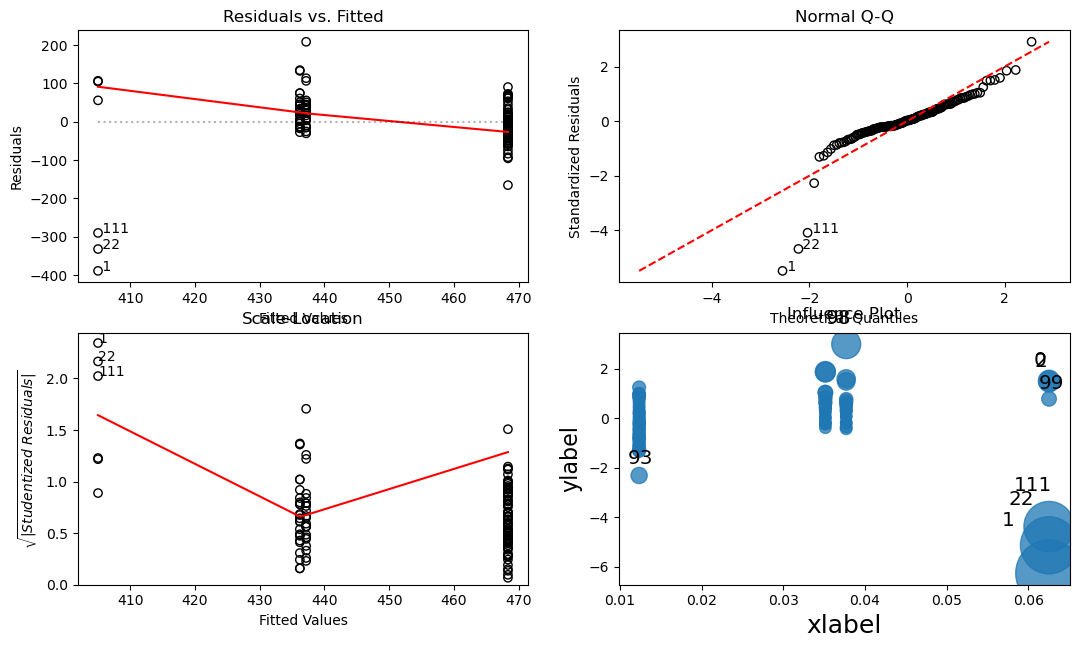

In [120]:
regression_diagnostic_plots(results)